In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline
import warnings, sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score, accuracy_score
from classification import Classification

In [2]:
data = pd.read_csv('../../Data/bank-direct-marketing.csv', sep=';')
data.head(2)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [9]:
data.shape

(41188, 21)

# 1. Exploratory Data Analysis

In [11]:
# check for any missing values and types of data, there is none
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [12]:
# an initial look at the distribution of the numerical columns
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### Lets look at the balance of classes of the y column
It is very important to know this class proportion as we are working on a classification problem. While training and testing, we need to ensure that same class distribution is represented in the sample data. A pie chart can help us with this.

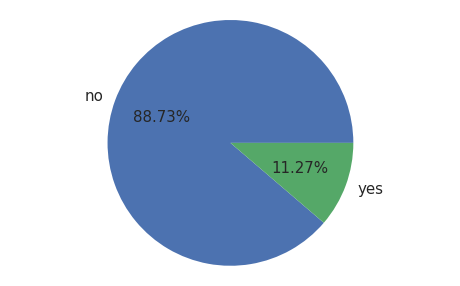

In [14]:
# distribution of the 'y' column, the outcome of the campaign
data.groupby('y').size().plot.pie(figsize=(8, 5), fontsize=15, autopct='%.2f%%')
plt.axis('equal')
plt.ylabel("")
plt.show()

### Lets look at the categorical columns and explore their relationship with the y columns. 
Plotting a stacked barplot will show us how each outcome of the marketing compaign is related to each categorical value in the categorical columns.

In [15]:
# list of names of categorical columns
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan',
               'contact', 'month', 'day_of_week', 'poutcome']

In [16]:
# function to create pivot table with count of rows for each category in a category column, split by y
def column_pivotable(column, df):
    return data.pivot_table(values='euribor3m', index=column, columns='y', aggfunc='count')\
            .sort_values(by='no', ascending=False)

# function to calculate percentage of y column for each category in each categorical column
def get_y_proportion(column, df):
    temp_df = data.groupby([column, 'y',]).size().sort_values(ascending=False)
    temp_df_index = list(temp_df.reset_index().iloc[:,0].values)
    return temp_df.groupby(level=0).apply(lambda x: round(100 * x / float(x.sum()), 2)).unstack() \
    .reindex([i for n,i in enumerate(temp_df_index) if i not in temp_df_index[:n]]) 

def plot_params(column):   
    plt.ylabel(column, fontsize=18) 
    plt.xlabel('')
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12, rotation=45)
    plt.legend(bbox_to_anchor=(1.15, 1), fontsize=13)

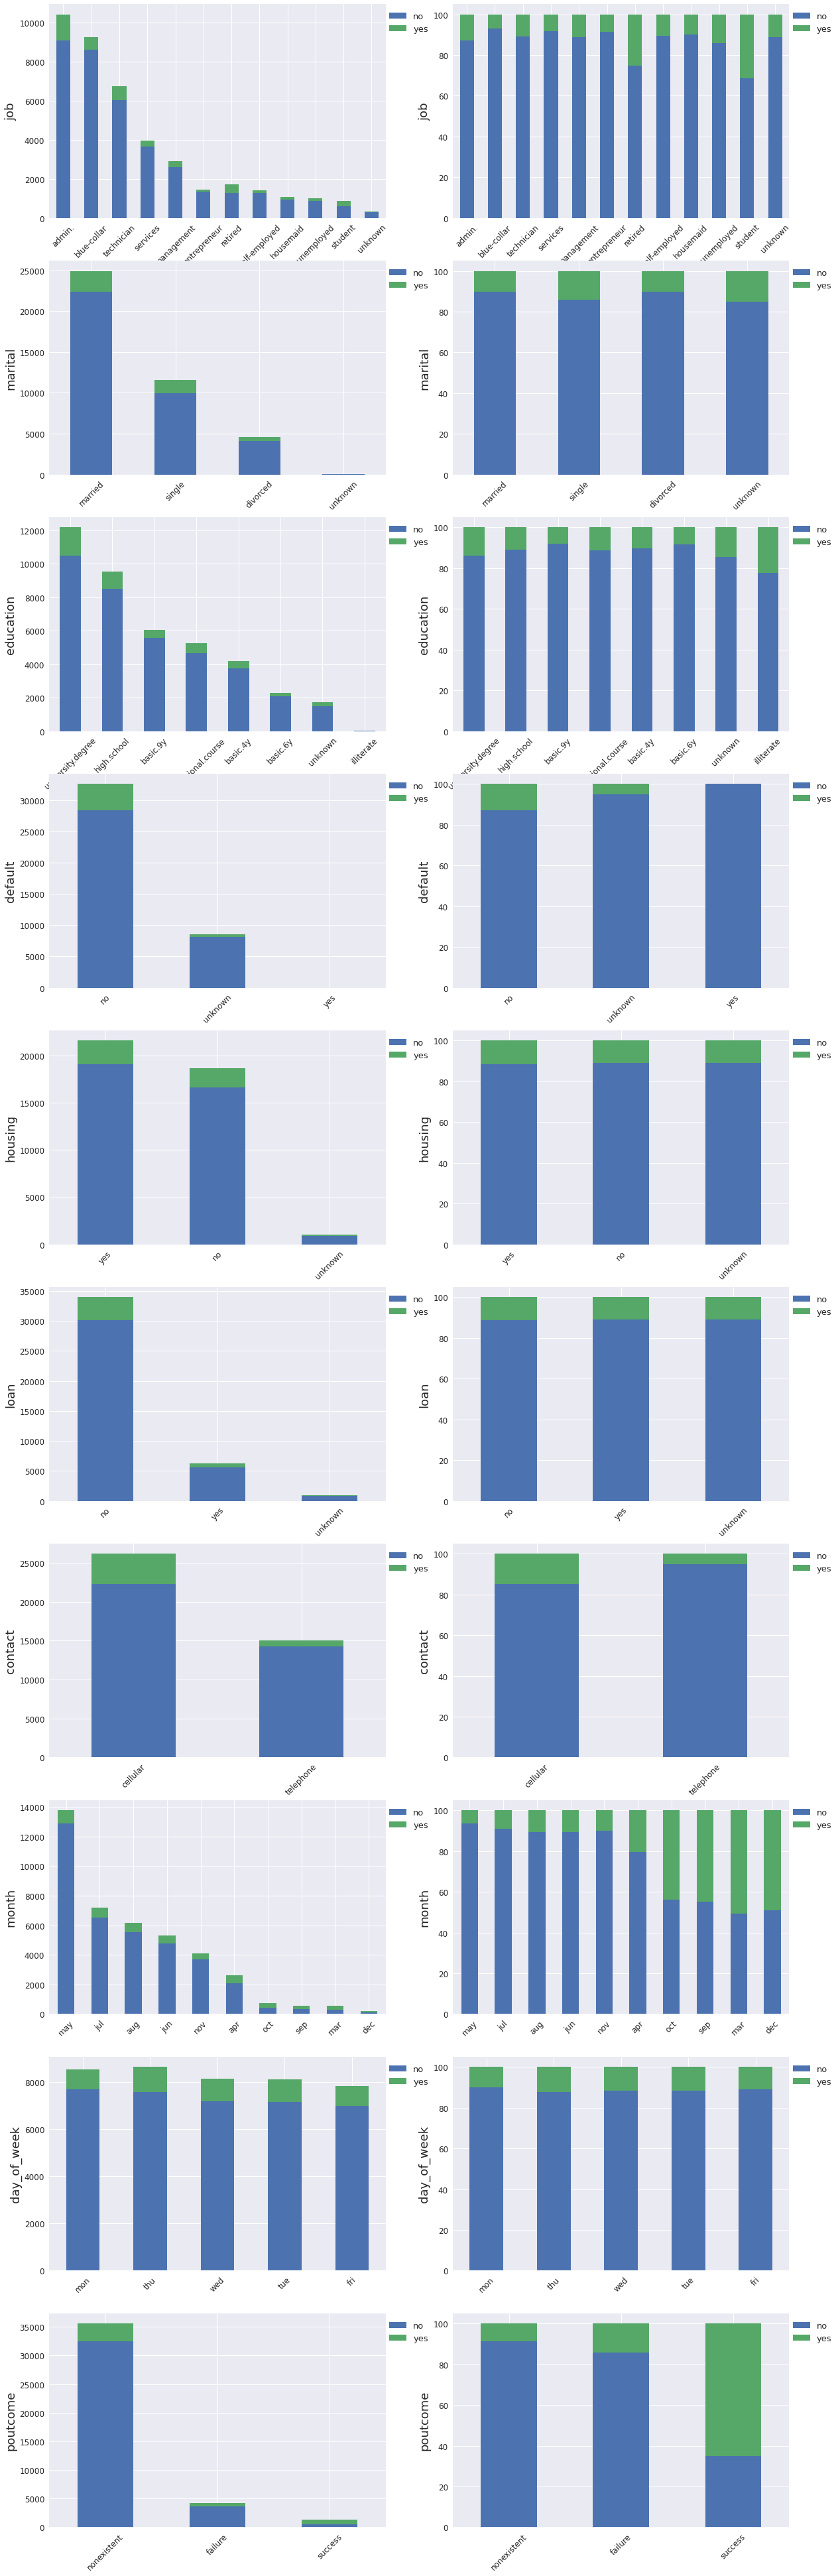

In [13]:
fig = plt.figure(figsize=(20, 70))
for i, column in enumerate(cat_columns):
    axs = fig.add_subplot(10, 2, (i*2)+1)
    column_pivotable(column, data).plot.bar(stacked=True, ax=axs)
    plot_params(column)
    axs = fig.add_subplot(10, 2, (i*2)+2)
    get_y_proportion(column, data).plot.bar(stacked=True, ax=axs)
    plot_params(column)
plt.show()

Based on the multiple barplots above, we can see the data is quite consistent across the categorical columns. We can also see the distribution of data rows for each category in each column.

There are few categorical columns which seem to indicate a certain relation with the outcome value. We can use a 100% stacked bar chart to understand this relationship.

### Lets look at the numerical columns and explore their relationship with the y column. 
Plotting a split boxplot will show us the distribution of each numerical column based on the outcome of the marketing compaign. These plots will also be useful in detecting any anomalies and outlies in the numerical columns.

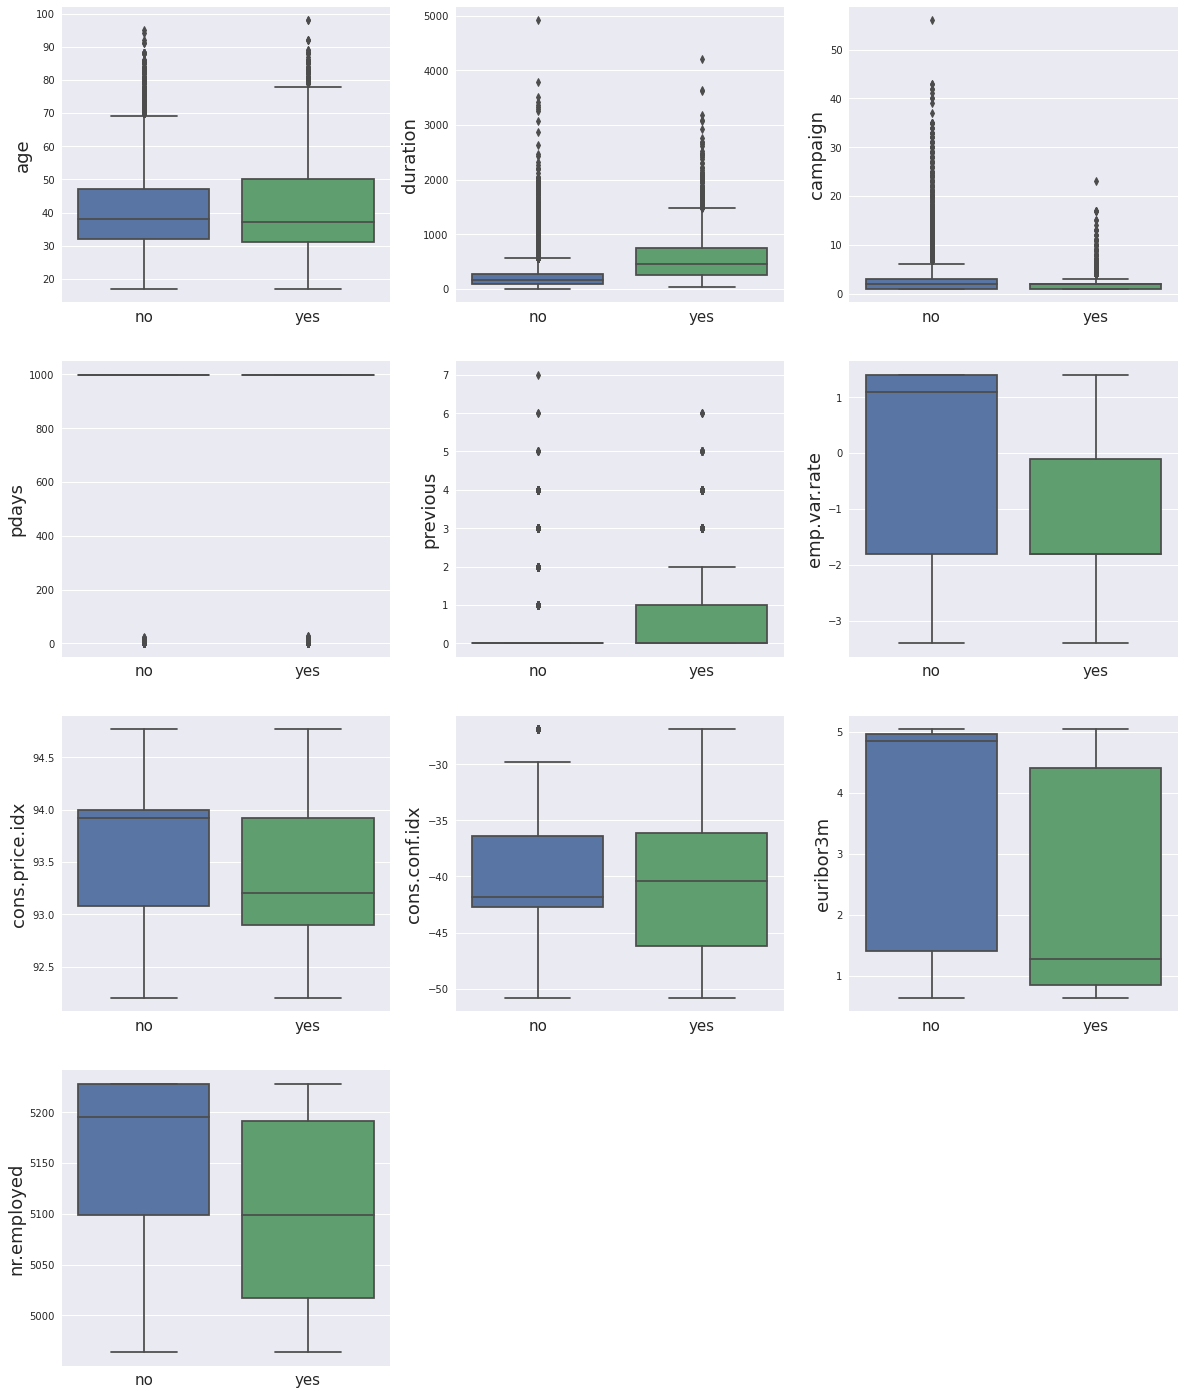

In [19]:
# lets look at the relationship of length of stays by adm_code - categorical data
num_columns = ['age','duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx',
               'cons.conf.idx', 'euribor3m', 'nr.employed']

fig = plt.figure(figsize=(20, 25))
for i, column in enumerate(num_columns):
    axs = fig.add_subplot(4, 3, i+1) 
    sns.boxplot(x='y', y=column, data=data, orient='v')  
    plt.xticks(fontsize=15, rotation=0)
    plt.xlabel('')
    plt.ylabel(column, fontsize=18) 
plt.show()

In [21]:
# Three variables seem a little odd and seem to have some outlers.
data[['campaign', 'pdays', 'previous']].describe()

,campaign,pdays,previous
count,41188.000000,41188.000000,41188.000000
mean,2.567593,962.475454,0.172963
std,2.770014,186.910907,0.494901
min,1.000000,0.000000,0.000000
25%,1.000000,999.000000,0.000000
50%,2.000000,999.000000,0.000000
75%,3.000000,999.000000,0.000000
max,56.000000,999.000000,7.000000


In [22]:
# Lets look at the percentage of rows with pdays=999, which means client was not previously contacted 
len(data[data['pdays'] == 999])/len(data)

0.9632174419733903

In [23]:
# Lets look at the percentage of rows with previous=0 
len(data[data['previous'] == 0])/len(data)

0.8634310964358551

In [24]:
# Lets look at the percentage of rows with campaign>10 
len(data[data['campaign'] > 10])/len(data)

0.021098378168398563

#### We do see that a lot pdays and previous variables have either 999 placeholder or 0 but this makes sense. There are also few rows where the campaign value is more than 10. For now, I don't see any issues in them so, we'll keep them as it is. 

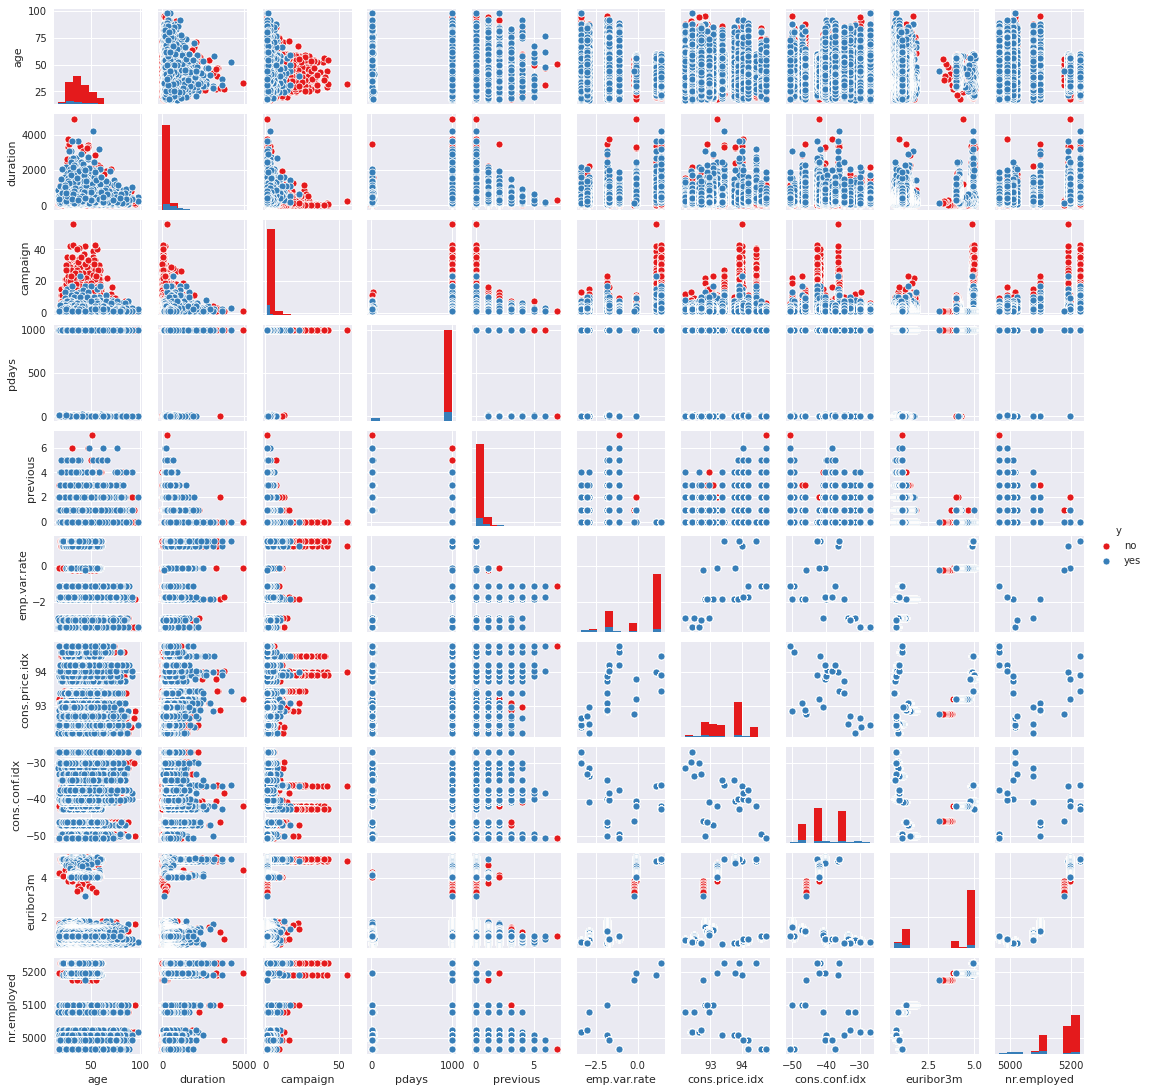

In [19]:
# scatter plots to explore the relationship among the numerical columns and histograms
sns.pairplot(data, diag_kind='hist',  hue= 'y', height=1.5, palette="Set1")
plt.show()

#### We do see a few variables that are highly correlated, eg. emp.var.rate, euribor3m and nr.employed are hghly correlated.

## 2. Preprocessing

In [3]:
# Lets first encode the taget y variable
label_encoder = LabelEncoder()
data_new = data.copy()

# drop the duration columns as it was suggested by the data source https://archive.ics.uci.edu/ml/datasets/bank+marketing
data_new.drop('duration', axis=1, inplace=True)
data_new['y'] = label_encoder.fit_transform(data['y'])

# One hot code the categorical variables and drop the first columns
data_new = pd.get_dummies(data_new, drop_first=True)

In [4]:
# Lets split the data in training and test sets with stratification to keep the proportion of y classes even
stratifier = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)

for train_index, test_index in stratifier.split(data_new, data_new['y']):
    train_data = data_new.loc[train_index]
    test_data = data_new.loc[test_index]

In [5]:
# Lets now further split the train and test sets to features and labels
xtrain = train_data.drop('y', axis=1)
ytrain = train_data['y']
xtest = test_data.drop('y', axis=1)
ytest = test_data['y']

## 3. Baseline Model

Here I use all the features generated from the initial 20 columns to build classifcation models. For this project I'll be using the following classifiers:
1. Gaussian Naive Bayes
2. Logistic Regression
3. Random Forest
4. XGBoost

In [6]:
# Create a dictionary of the classifiers
classifiers = {}
classifiers['GNB'] = GaussianNB()
classifiers['LR'] = LogisticRegression(random_state=10)
classifiers['RF'] = RandomForestClassifier(random_state=10)
classifiers['XGB'] = XGBClassifier(random_state=10)

# Create a dictionary with the parameters to train for the classifiers
parameters = {}
parameters['GNB'] = {'classifier__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
parameters['LR'] = {'classifier__penalty' : ['l1', 'l2'],
                    'classifier__solver': ['lbfgs', 'liblinear']}
parameters['RF'] = {'classifier__n_estimators': list(range(50, 450, 50))}
parameters['XGB'] = {'classifier__booster': ['gbtree', 'gblinear']}

In [7]:
# initialise the data
base_data = Classification( xtrain, ytrain, xtest, ytest)

# grid search for the best classifiers based on f1-score
base_result = base_data.grid_search(classifiers, parameters, score='f1')

In [8]:
# result comparison based on f1-score
base_data.model_comparison()

,model,train_score,crossVal_mean_score,test_score,refit_time
0,GNB,0.418,0.415,0.411,0.163
1,LR,0.347,0.346,0.342,0.466
2,RF,0.978,0.381,0.395,8.563
3,XGB,0.585,0.385,0.374,2.688


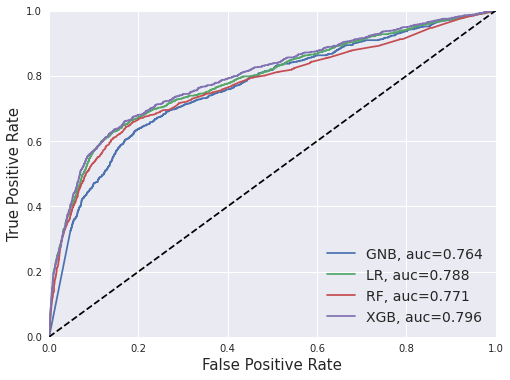

In [9]:
# result comparison based on ROC-AUC
base_data.plot_rocs()

In [10]:
print(confusion_matrix(ytest, base_result['GNB']['model'].best_estimator_.predict(xtest)))
print(classification_report(ytest, base_result['GNB']['model'].best_estimator_.predict(xtest)))

[[6263 1047]
 [ 417  511]]
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7310
           1       0.33      0.55      0.41       928

    accuracy                           0.82      8238
   macro avg       0.63      0.70      0.65      8238
weighted avg       0.87      0.82      0.84      8238



In [57]:
# function to select threshold for best f1-score
def best_threshold(model, xtest, ytest=ytest):
    y_probs = model.predict_proba(xtest)[:, 1]
    thresholds = np.arange(0, 1, 0.001)
    f1_scores = [f1_score(ytest, (y_probs>=threshold).astype('int')) for threshold in thresholds]  
    ix = np.argmax(f1_scores)
    return round(f1_scores[ix], 2), thresholds[ix]

In [58]:
# compare the best f1-scores and their respective thresholds
for k, v in base_result.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_, xtest)}")

GNB: (0.42, 0.996)
LR: (0.49, 0.20400000000000001)
RF: (0.47, 0.28600000000000003)
XGB: (0.5, 0.193)


## 4. Feature Selection

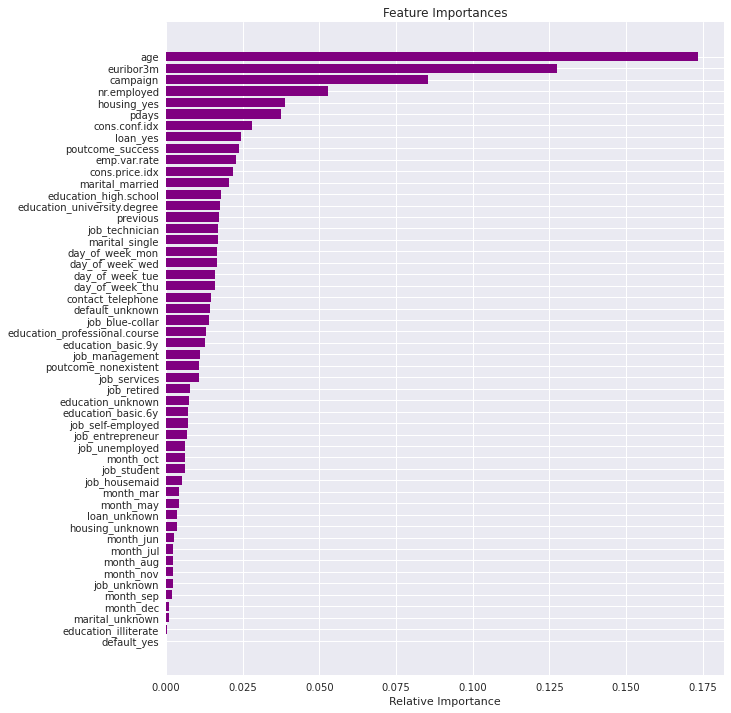

In [16]:
# lets use the Random Forest model to rank the importance of features
model = base_result['RF']['model'].best_estimator_.steps[1][1]
features = xtrain.columns
importances = model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='purple', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [17]:
# Lets rank the features in order of importance, remove 'duration' from the list
features_ranked = [features[i] for i in np.argsort(importances)[::-1]]

In [30]:
# Lets now cross validate and calculate the mean accuracy for featured ranked combinations with a Random Forest
mean_accuracy = {}
pbar = tqdm.tqdm(total=len(features_ranked))
for i in range(len(features_ranked)):
    x_train = xtrain.loc[:,features_ranked[:i+1]]
    score = train_model('RF', x_train).best_score_
    mean_accuracy[i+1] = score
    pbar.update(1)


100%|██████████| 62/62 [43:01<00:00, 53.86s/it]

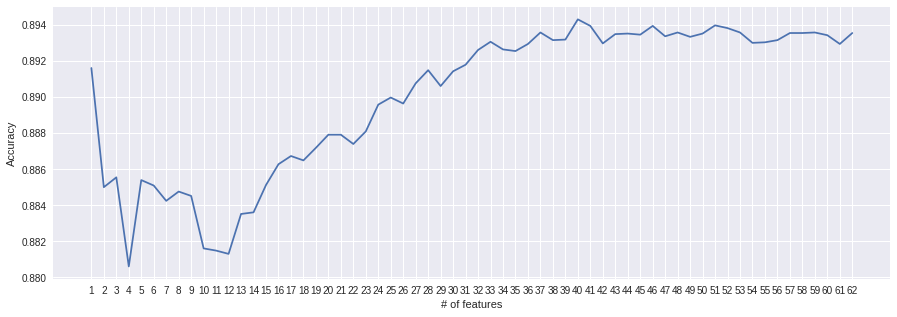

In [32]:
# Lets look at the change in mean accuracy with feature combinations
plt.figure(figsize=(15,5))
plt.plot(list(mean_accuracy.values()))
plt.ylabel('Accuracy')
plt.xlabel('# of features')
plt.xticks(range(len(mean_accuracy)), mean_accuracy.keys())
plt.show()

In [20]:
# # Pearson’s Correlations among the nmerical columns
# plt.figure(figsize=(15, 10))
# sns.heatmap(data.loc[:, num_columns].corr(method='pearson'), annot=True)
# plt.show()
round(data.loc[:, num_columns].corr(method='pearson'), 2)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.00,-0.00,0.00,-0.03,0.02,-0.00,0.00,0.13,0.01,-0.02
duration,-0.00,1.00,-0.07,-0.05,0.02,-0.03,0.01,-0.01,-0.03,-0.04
campaign,0.00,-0.07,1.00,0.05,-0.08,0.15,0.13,-0.01,0.14,0.14
pdays,-0.03,-0.05,0.05,1.00,-0.59,0.27,0.08,-0.09,0.30,0.37
previous,0.02,0.02,-0.08,-0.59,1.00,-0.42,-0.20,-0.05,-0.45,-0.50
emp.var.rate,-0.00,-0.03,0.15,0.27,-0.42,1.00,0.78,0.20,0.97,0.91
cons.price.idx,0.00,0.01,0.13,0.08,-0.20,0.78,1.00,0.06,0.69,0.52
cons.conf.idx,0.13,-0.01,-0.01,-0.09,-0.05,0.20,0.06,1.00,0.28,0.10
euribor3m,0.01,-0.03,0.14,0.30,-0.45,0.97,0.69,0.28,1.00,0.95
nr.employed,-0.02,-0.04,0.14,0.37,-0.50,0.91,0.52,0.10,0.95,1.00


In [21]:
# remove correlated numerical variables
features_1 = [feature for feature in features_ranked[:40] if feature not in
              ('cons.conf.idx', 'emp.var.rate', 'nr.employed')]
len(features_1)

37

In [48]:
# subset the train and test sets with only top 37 features
xtrain_37 = xtrain.loc[:,features_1]
xtest_37 = xtest.loc[:,features_1]

In [49]:
# grid search with the top 37 features 
data_37features = Classification(xtrain_37, ytrain, xtest_37, ytest)
result_37features = data_37features.grid_search(classifiers, parameters, score='f1')

In [50]:
data_37features.model_comparison()

,model,train_score,crossVal_mean_score,test_score,refit_time
0,GNB,0.412,0.412,0.412,0.066
1,LR,0.326,0.322,0.326,0.456
2,RF,0.976,0.371,0.383,12.546
3,XGB,0.583,0.386,0.380,2.059


In [59]:
# compare the best f1-scores and their respective thresholds
for k, v in result_37features.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_, xtest_37)}")

GNB: (0.42, 0.712)
LR: (0.47, 0.219)
RF: (0.46, 0.216)
XGB: (0.5, 0.216)


## 5. Resampling techniques

In [60]:
# oversampling 
os_data37 = Classification(xtrain_37, ytrain, xtest_37, ytest)
os_data37.resample('over')

# let's look at the class distribution of the train set after sampling
os_data37.ytrain.value_counts()

1    29238
0    29238
Name: y, dtype: int64

In [61]:
# grid search 
result_os_data37 = os_data37.grid_search(classifiers, parameters, score='f1')

In [62]:
os_data37.model_comparison()

,model,train_score,crossVal_mean_score,test_score,refit_time
0,GNB,0.571,0.571,0.390,0.131
1,LR,0.721,0.720,0.423,0.737
2,RF,0.997,0.969,0.429,5.453
3,XGB,0.840,0.814,0.443,3.904


In [63]:
# compare the best f1-scores and their respective thresholds
for k, v in result_os_data37.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_, xtest_37)}")

GNB: (0.42, 0.9490000000000001)
LR: (0.47, 0.665)
RF: (0.46, 0.391)
XGB: (0.47, 0.682)


In [64]:
# undersampling 
us_data37 = Classification(xtrain_37, ytrain, xtest_37, ytest)
us_data37.resample('under')

# let's look at the class distribution of the train set after sampling
us_data37.ytrain.value_counts()

1    3712
0    3712
Name: y, dtype: int64

In [66]:
result_us_data37 = us_data37.grid_search(classifiers, parameters, score='f1')
us_data37.model_comparison()

,model,train_score,crossVal_mean_score,test_score,refit_time
0,GNB,0.675,0.674,0.266,0.011
1,LR,0.771,0.765,0.247,0.141
2,RF,0.977,0.719,0.246,2.667
3,XGB,0.771,0.765,0.247,0.142


In [67]:
# smote-tomek
smt_data37 = Classification(xtrain_37, ytrain, xtest_37, ytest)
smt_data37.resample('smote')

# let's look at the class distribution of the train set after sampling
smt_data37.ytrain.value_counts()

1    29192
0    29192
Name: y, dtype: int64

In [68]:
result_smt_data37 = smt_data37.grid_search(classifiers, parameters, score='f1')
smt_data37.model_comparison()

,model,train_score,crossVal_mean_score,test_score,refit_time
0,GNB,0.772,0.767,0.350,0.077
1,LR,0.849,0.833,0.352,0.525
2,RF,0.997,0.923,0.428,17.970
3,XGB,0.942,0.900,0.430,3.834


In [69]:
# compare the best f1-scores and their respective thresholds
for k, v in result_smt_data37.items():
    print(f"{k}: {best_threshold(v['model'].best_estimator_, xtest_37)}")

GNB: (0.4, 0.988)
LR: (0.37, 0.62)
RF: (0.46, 0.396)
XGB: (0.45, 0.34500000000000003)


## 6. Model selection

In [73]:
# The best f1-score achieved was with the XGBoost model with 37 features with over-resampling 
# Lets get its parameters
result_os_data37['XGB']['model'].best_params_

{'classifier__booster': 'gbtree'}

In [72]:
# Lets get the names of 37 features
xtrain_37.columns

Index(['age', 'euribor3m', 'campaign', 'housing_yes', 'pdays', 'loan_yes',
       'poutcome_success', 'cons.price.idx', 'marital_married',
       'education_high.school', 'education_university.degree', 'previous',
       'job_technician', 'marital_single', 'day_of_week_mon',
       'day_of_week_wed', 'day_of_week_tue', 'day_of_week_thu',
       'contact_telephone', 'default_unknown', 'job_blue-collar',
       'education_professional.course', 'education_basic.9y', 'job_management',
       'poutcome_nonexistent', 'job_services', 'job_retired',
       'education_unknown', 'education_basic.6y', 'job_self-employed',
       'job_entrepreneur', 'job_unemployed', 'month_oct', 'job_student',
       'job_housemaid', 'month_mar', 'month_may'],
      dtype='object')

I'll now use the XGBoost classifier with param booster=gbtree and use over-sampling to pedict the likelihood of a conversion. The test data will use the 37 features listed above after one-hot encoding of categorical data.

The predict.py will generate the predictions